# **DataScience**

# **1. Bucket**



### **Autenticación Google Colab**

In [ ]:
# Autenticación con Google Colab
from google.colab import auth

auth.authenticate_user()
print('Authenticated')

Authenticated


## **Conexión al Bucket de Google Cloud**

In [ ]:
from google.cloud import storage

client = storage.Client()
bucket = client.get_bucket('act_transf_datos_masivos')

print(f'Conectado al bucket: {bucket.name}')

Forbidden: 403 GET https://storage.googleapis.com/storage/v1/b/act_transf_datos_masivos?projection=noAcl&prettyPrint=false: jarc2802@gmail.com does not have storage.buckets.get access to the Google Cloud Storage bucket. Permission 'storage.buckets.get' denied on resource (or it may not exist).

In [ ]:
# Función para subir archivos al bucket
def upload_blob(client, bucket_name, source_file_name, destination_blob_name):
    """Subir un archivo a un bucket de Google Cloud Storage."""
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(f'Archivo {source_file_name} subido a gs: //{bucket.name}/{destination_blob_name}.')

## **Subiendo los archivos al bucket**

* **Arhivos csv:** reviews del scrapping y análsis de sentimiento (BERT).
* **Archivo xlsx:** Encuesta.

In [ ]:
upload_blob(client, 'act_transf_datos_masivos', '/content/reviews_scrapping.csv', 'reviews_scrapping.csv')
upload_blob(client, 'act_transf_datos_masivos', '/content/sentiment_analysis.csv', 'sentiment_analysis.csv')
upload_blob(client, 'act_transf_datos_masivos', '/content/Encuesta_de_Opinión_sobre_el_ZTE_Blade_A5_2020nm.xlsx', 'encuesta.xlsx')

El archivo csv con los reviews y el análsis de sentimiento con BERT y la encuesta fueron subidos con éxito al Bucket.

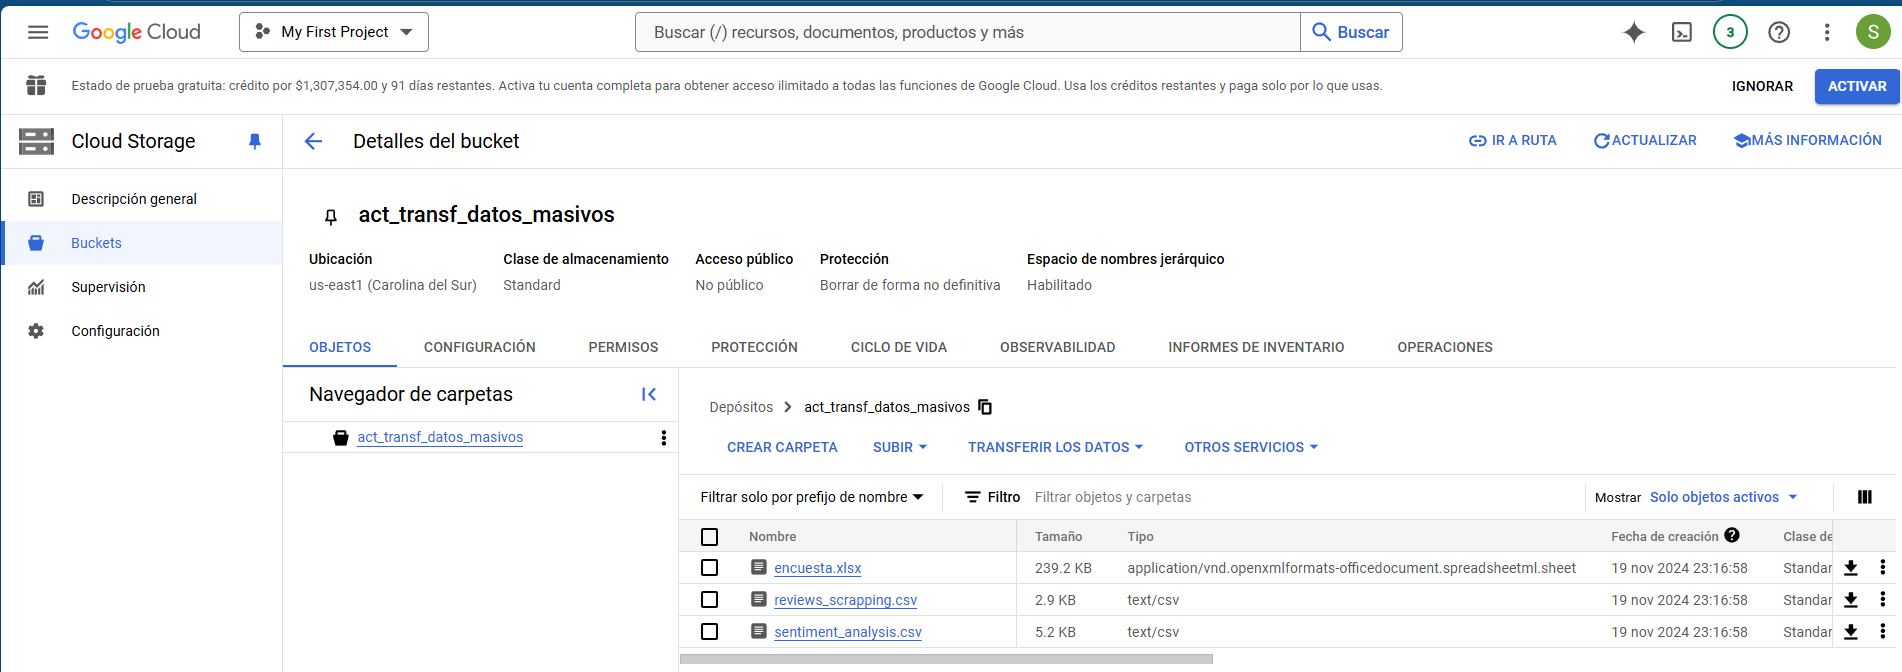

# **2. Data Warehouse con SQLite**

In [ ]:
import sqlite3

# Creamos la conexión a la BD con el método connect
conn = sqlite3.connect('/content/reviews_scrapping.db')

## **Creando la tabla en la BD**

In [ ]:
# Creando las tablas en las que se van a cargar los reviews (scrappeadas) y el análsis de sentimiento
cursor = conn.cursor()

cursor.execute('''
CREATE TABLE IF NOT EXISTS reviews(
 id integer primary key,
 Usuario text,
 Date text,
 Rating integer,
 Comment text,
 Sentiment text,
 Score real,
 Comment_preprocessed text
)
''')

conn.commit()

In [ ]:
query = cursor.execute(
    '''
SELECT * FROM reviews
'''
)
print(query.fetchall())

# **4. Análisis de sentimiento con BERT**

Este paso es necesario porque se debe subir el resultado del análisis de sentimiento a la BD de SQLite (Data Warehouse del Punto 2).

## **4.1. Librerías**

In [ ]:
!pip install requests
!pip install pandas
!pip install numpy
!pip install transformers

In [ ]:
import requests
import json
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import re
from datetime import datetime

## **4.2. Scrapper**

In [ ]:
# URL de los comentarios del producto en documento JSON
url = 'https://www.mercadolibre.com.co/noindex/catalog/reviews/MCO16518530/search?objectId=MCO16518530&siteId=MCO&isItem=false&rating=&order=&offset=0&limit=30&x-is-webview=false'

# Solicitud GET a la URL
response = requests.get(url)
if response.status_code == 200:
    print(f'Solicitud exitosa con estado: {response}')
else:
    print('Solicitud no exitosa')

Solicitud exitosa con estado: <Response [200]>


### **Calificación y texto de reviews**

In [ ]:
# Diccionario para traducir los meses del español al inglés
meses = {
    'ene.': 'Jan', 'feb.': 'Feb', 'mar.': 'Mar', 'abr.': 'Apr', 'may.': 'May', 'jun.': 'Jun',
    'jul.': 'Jul', 'ago.': 'Aug', 'sep.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'dic.': 'Dec'
}

data = response.json()
reviews = data['reviews']
ratings = []
comments = []
dates = []

for review in reviews:
    date_str = review['comment']['time']['text']  # Extrayendo la fecha del comentario
    rating = review['aria_label']  # Extrayendo la calificación desde 'aria_label' del JSON
    text = review['comment']['content']['text']

    # Reemplazando el mes en español por el mes en inglés
    for mes_es, mes_en in meses.items():
        date_str = date_str.replace(mes_es, mes_en)

    # Convertiendo la fecha al formato YYYY-MM-DD
    date_obj = datetime.strptime(date_str, '%d %b %Y')
    date_formatted = date_obj.strftime('%Y-%m-%d')

    # Usamos una expresión regular para extraer el número de la calificación
    rating_num = int(re.search(r'(\d)', rating).group(1))

    dates.append(date_formatted)
    ratings.append(rating_num)
    comments.append(text)

# DataFrame
df = pd.DataFrame({'Date': dates, 'Rating': ratings, 'Comment': comments})
df['Usuario'] = ['usuario_' + str(i+1) for i in range(len(df))]
df = df[['Usuario', 'Date', 'Rating', 'Comment']]

display(df)

,Usuario,Date,Rating,Comment
0,usuario_1,2023-10-01,5,"Hay que ser objetivos, para el precio es muy b..."
1,usuario_2,2024-01-05,5,Buen producto y relación calidad precio.
2,usuario_3,2022-01-10,5,"Es un equipo básico pero muy funcional, toma b..."
3,usuario_4,2024-01-21,4,"La verdad es que esta bueno para lo básico, es..."
4,usuario_5,2024-09-30,5,Apenas se está probando y todo muy bien. Si al...
5,usuario_6,2024-09-29,5,Aún lo estamos ensayando pero hasta ahora ah s...
6,usuario_7,2024-11-09,5,Super.
7,usuario_8,2024-10-28,5,Muy buen producto a bueb precio. Los audífonos...
8,usuario_9,2024-10-26,5,Muy buen producto cumple sus espectativas.
9,usuario_10,2024-10-14,5,Es un buen celular duradero para mis actividades.


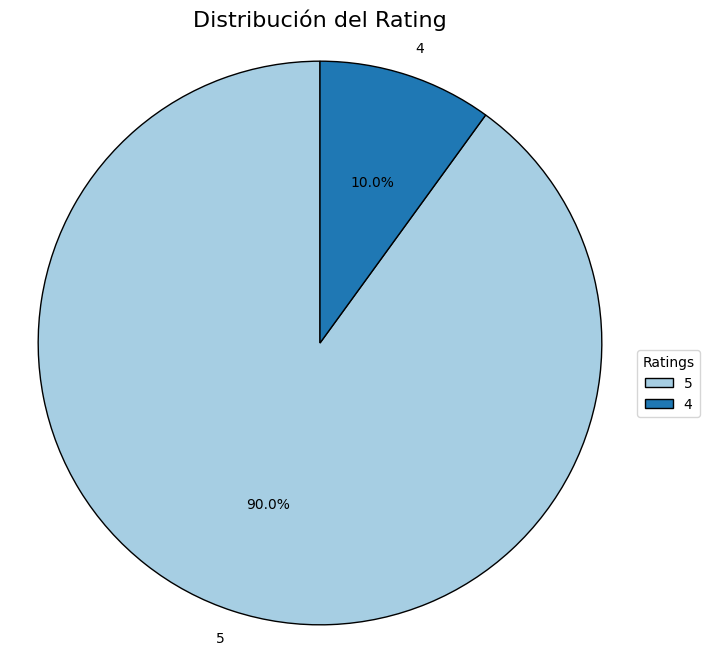

In [ ]:
# Assuming your data is in a pandas DataFrame called 'df'
rating_counts = df['Rating'].value_counts()
# Definiendo colores para el gráfico de pastel
colors = plt.cm.Paired(range(len(rating_counts)))

# Creando el gráfico de pastel con estilo adicional
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'})
plt.title('Distribución del Rating', fontsize=16)
plt.axis('equal')  # La relación de aspecto igual asegura que el pastel se dibuje como un círculo.

# Añadir una leyenda
plt.legend(title='Ratings', loc='upper left', bbox_to_anchor=(1, 0.5))

# Mostrar el gráfico
plt.show()

**NOTA:** En esta versión agregamos la fecha del comentario y dejamos solo el valor numérico del rating (antes estaba algo como "Calificación 4 de 5").

## **4.3. Modelo BERT**

In [ ]:
# Modelo y tokenizador de BETO
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Creando el pipeline de análisis de sentimiento
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
# Función para analizar el sentimiento
def analizar_sentimiento_beto(texto):
    result = sentiment_analysis(texto)[0]
    score = result['score']

    # Determinar el sentimiento basado en el score
    if score >= 0.55:
        sentiment = 'Positivo'
    elif score <= 0.45:
        sentiment = 'Negativo'
    else:
        sentiment = 'Neutral'

    return sentiment, score

# Aplicando el análisis de sentimiento
df['Sentiment'], df['Score'] = zip(*df['Comment'].apply(analizar_sentimiento_beto))
display(df.head())

,Usuario,Date,Rating,Comment,Sentiment,Score
0,usuario_1,2023-10-01,5,"Hay que ser objetivos, para el precio es muy b...",Neutral,0.470996
1,usuario_2,2024-01-05,5,Buen producto y relación calidad precio.,Neutral,0.493209
2,usuario_3,2022-01-10,5,"Es un equipo básico pero muy funcional, toma b...",Neutral,0.503735
3,usuario_4,2024-01-21,4,"La verdad es que esta bueno para lo básico, es...",Positivo,0.563026
4,usuario_5,2024-09-30,5,Apenas se está probando y todo muy bien. Si al...,Negativo,0.387667


In [ ]:
sentimiento_counts = df['Sentiment'].value_counts()
display(sentimiento_counts)

,count
Sentiment,
Positivo,18
Neutral,10
Negativo,2


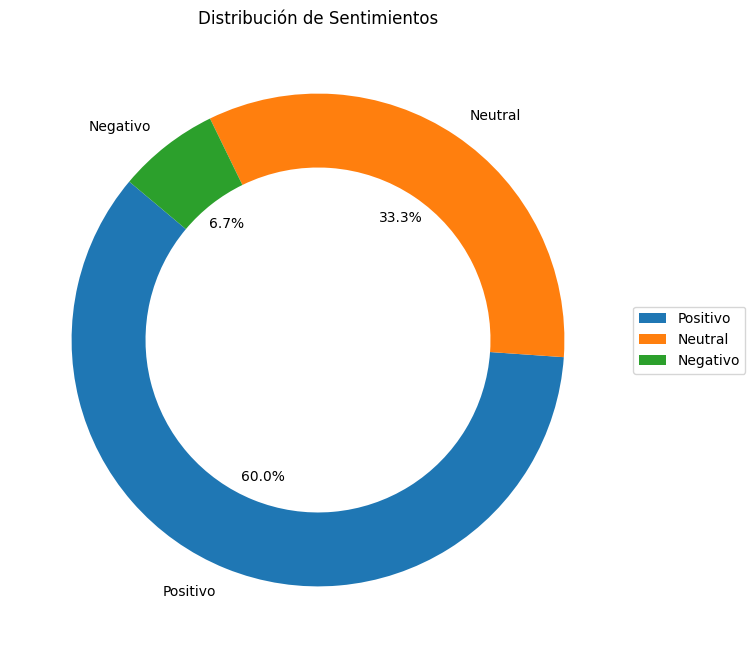

In [ ]:
import matplotlib.pyplot as plt

# Generando el gráfico de dona
plt.figure(figsize=(8, 8))
plt.pie(sentimiento_counts, labels=sentimiento_counts.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Distribución de Sentimientos')
plt.legend(sentimiento_counts.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

### **Preprocesamiento de comments**

Importante en esta etapa para el modelo que entrenaremos luego

In [ ]:
from types import prepare_class
import re, nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def data_processor(data):
  preprocessed_data = []
  for text in data:
    # convertir en minuscula
    text = str(text).lower()
    # eliminar signos de puntuacion
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenizar
    words = word_tokenize(text)
    # eliminar stopwords
    words = [word for word in words if word not in stop_words]
    # lematización
    words = [lemmatizer.lemmatize(word) for word in words]
    preprocessed_text = ' '.join(words)
    preprocessed_data.append(preprocessed_text)
  return preprocessed_data

df['Comment_preprocessed'] = data_processor(df['Comment'])
display(df.head())

### **Verificaciones preliminares antes de subir al Warehouse**

In [ ]:
# Eliminando registros duplicados
df = df.drop_duplicates()
# Rellenando valores nulos con un valor predeterminado
df['Rating'] = df['Rating'].fillna(0)
# Convertir una columna de texto a fecha
#df['Date'] = pd.to_datetime(df['Date'])
# Convertir una columna de texto a numérico
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df.head()

In [ ]:
# Verificación de valores nulos
print(df.isnull().sum())

In [ ]:
# Resumen estadístico de columnas numéricas
df.describe()

Esto tiene sentido porque la mayoría de calificaciónes de los usuarios eran 5 de 5 y unas pocas 4 de 5.

In [ ]:
# Boxplot para mirar datos atíplicos
df.boxplot(column=['Rating'])

De nuevo, el rating en su mayoría es 5 de 5 y unos pocos 4 de 5. Además, el rating es un valor discreto.

In [ ]:
df.head()

## **4.4. Subiendo el Dataframe al Warehouse de la seccipón 2**

Guardando en la BD de SQLite con el métdo to_sql.

La tabla en la BD se llama reviews, la conexión es conn (numeral 2).

In [ ]:
#df.to_sql('reviews', conn, if_exists='append', index=False)
df.to_sql('reviews', conn, if_exists='replace', index=False)

Se tuvo que usar replace porque no permitió usar el método append.

### **Queries dentro de la BD**

In [ ]:
# Consulta para verificar datos
query = cursor.execute('''
select * from reviews
''')
print(query.fetchall())

### **Query contando el cuántos sentiment hay por tipo**

In [ ]:
query = cursor.execute('''
select count(*), sentiment
from reviews
group by sentiment
''')
print(query.fetchall())

[(2, 'Negativo'), (10, 'Neutral'), (18, 'Positivo')]


## **4.5. Palabras clave más relevantes**

In [ ]:
!pip install sklearn
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install collectios

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
ERROR: Could not find a version that satisfies the requirement collectios (from versions: none)
ERROR: No matching distribution found for collectios


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Descargar las stopwords en español de NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Configurar las stopwords en español
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<ipython-input-102-895620975c7a>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frecuencia', y='Palabra', data=top_words, palette='viridis')


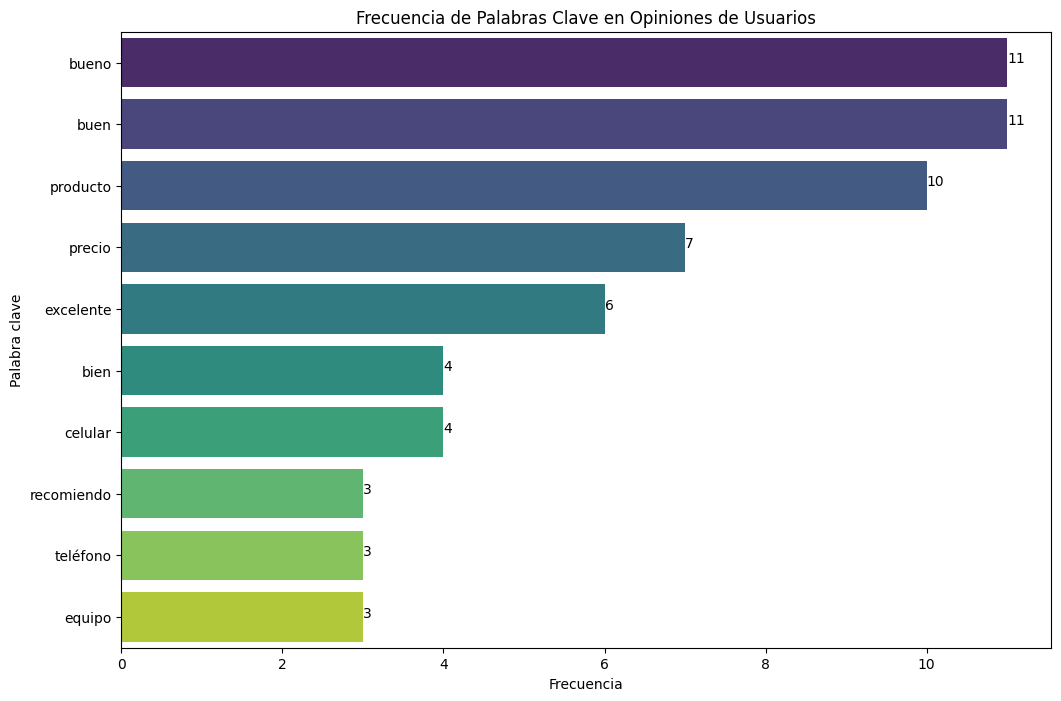

In [ ]:
# Tokenizando y filtrando palabras clave
all_words = []
for comment in df['Comment_preprocessed']:
    words = word_tokenize(comment)
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    all_words.extend(filtered_words)

# Conteo de frecuencia de las palabras clave
word_freq = Counter(all_words)

# Convirtiendo a DataFrame para facilitar el análisis
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Palabra', 'Frecuencia'])

# Ordenando por frecuencia descendente
word_freq_df = word_freq_df.sort_values(by='Frecuencia', ascending=False)

# Mostrando lel Top-10 de palabras clave
top_words = word_freq_df.head(10)

# Visualizando las frecuencias de las palabras clave más mencionadas
plt.figure(figsize=(12, 8))
sns.barplot(x='Frecuencia', y='Palabra', data=top_words, palette='viridis')
plt.title('Frecuencia de Palabras Clave en Opiniones de Usuarios')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra clave')

# Añadir los números en cada barrita
for index, value in enumerate(top_words['Frecuencia']):
    plt.text(value, index, str(value))
plt.show()

# **3. Entrenando un modelo de clasificación**

Requerimos un modelo de clasificación porque lo que vamos a entrenar son categorías. Los labels de los sentimientos (negativo, neutral y positivo) y los comentarios son strings.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Definiendo las características (X) y la variable objetivo (y)
review  = df['Comment_preprocessed']
label = df['Sentiment']

In [ ]:
# Dividiendo los datos en conjuntos de entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(review, label, test_size=0.2, random_state=2)

In [ ]:
# Convertiendo los textos en vectores de características
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

### **Logit multinomial**

#### **Ingenieria de features (hierparámetros)**

In [ ]:
# Definiendo el modelo de regresión logística multinomial
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, random_state=2)

# Sugeriendo algunos hiperparámetros comunes para el ajuste
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'saga']
}

# Aplicando GridSearchCV para encontrar los mejores parámetros
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_vec, y_train)

# Mejor modelo encontrado por GridSearchCV
best_clf = grid_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [ ]:
print(best_clf)

LogisticRegression(C=0.01, max_iter=200, multi_class='multinomial',
                   random_state=2, solver='newton-cg')


In [ ]:
# Predicciones con el modelo sugerido por GridSearch solver
y_pred = best_clf.predict(X_test_vec)

In [ ]:
# Evaluar el modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00         3
    Positivo       0.50      1.00      0.67         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Exploración otros modelos de entrenamieto:**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Usuario               30 non-null     object 
 1   Date                  30 non-null     object 
 2   Rating                30 non-null     int64  
 3   Comment               30 non-null     object 
 4   Sentiment             30 non-null     object 
 5   Score                 30 non-null     float64
 6   Comment_preprocessed  30 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 1.8+ KB


Distribución de clases después de SMOTE:
Sentiment
Neutral     15
Positivo    15
Negativo    15
Name: count, dtype: int64

Training Logistic Regression...
Logistic Regression Accuracy: 0.0000
Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       3.0
    Positivo       0.00      0.00      0.00       3.0

    accuracy                           0.00       6.0
   macro avg       0.00      0.00      0.00       6.0
weighted avg       0.00      0.00      0.00       6.0


Training Decision Tree...
Decision Tree Accuracy: 0.1667
Decision Tree Classification Report:
              precision    recall  f1-score   support

     Neutral       0.25      0.33      0.29         3
    Positivo       0.00      0.00      0.00         3

    accuracy                           0.17         6
   macro avg       0.12      0.17      0.14         6
weighted avg       0.12      0.17      0.14         6


Training Random

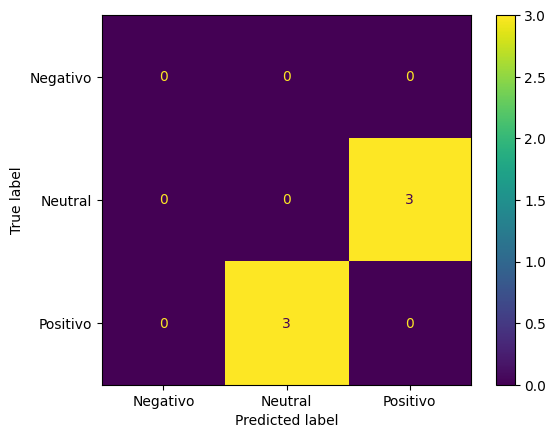

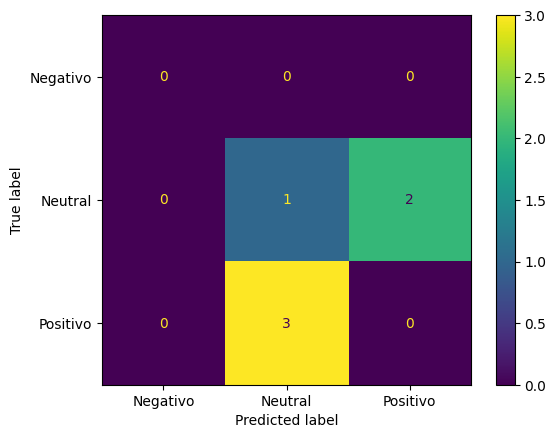

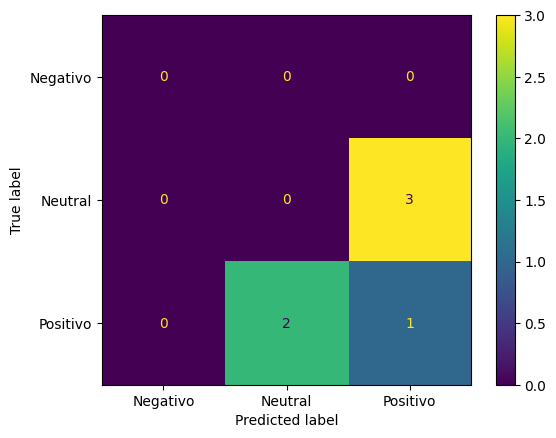

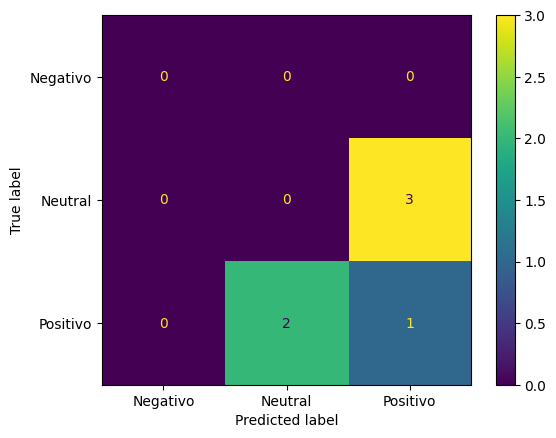

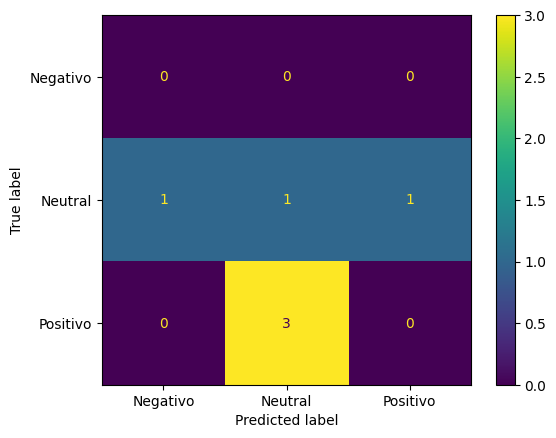

In [ ]:
# Importar librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Vectorización de los textos
vectorizer = TfidfVectorizer(min_df=1, max_df=0.8, ngram_range=(1, 3))
X = vectorizer.fit_transform(df['Comment_preprocessed'])
y = df['Sentiment']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balancear las clases con SMOTE
smote = SMOTE(k_neighbors=1, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verificar distribución de clases balanceadas
print("Distribución de clases después de SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

# Modelos con class_weight para balanceo
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
    "Naive Bayes": MultinomialNB()  # No aplica class_weight
}

# Entrenar y evaluar modelos
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Entrenar el modelo
    model.fit(X_train_balanced, y_train_balanced)

    # Predicción en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Evaluar el modelo
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    results[name] = {
        "Accuracy": acc,
        "Classification Report": report
    }

    # Mostrar métricas y matriz de confusión
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} Classification Report:\n{report}")
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')

# Resumen de resultados
summary = pd.DataFrame({name: results[name]['Accuracy'] for name in results.keys()}, index=["Accuracy"])
print("\nSummary of Results:")
print(summary.T)


**Problemas Potenciales**
Desbalance severo de clases: Aunque se aplicó SMOTE o submuestreo, el desbalance inicial puede haber causado que los modelos no aprendan correctamente.

**Conjunto de datos pequeño: Un dataset con solo 30 observaciones es demasiado pequeño para entrenar modelos de clasificación de manera efectiva.**

Representación de texto insuficiente: Es posible que el vectorizador TF-IDF no esté capturando la información relevante de los textos debido a parámetros subóptimos o falta de datos.


**Muchahos aca creo que uno podría seguir intentando ajustar cosas pero es que realmente el dataframe no ayuda por la cantidad tan limitada de comentarios.**